In [13]:
#https://github.com/arvin2911/EE399/tree/HW6

In [12]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

In [3]:


train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [4]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)

epoch: 40 valid_error: tensor(0.2163): 100%|████| 50/50 [13:00<00:00, 15.62s/it]


In [5]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.037312657


In [6]:
from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

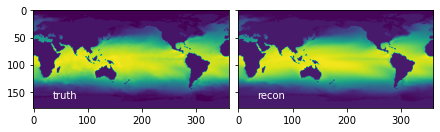

In [7]:
plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

In [9]:


result = []
recons_final = []

for lags in time_lags:
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=20, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    result.append((lags, error))
    recons_final.append(test_recons)


epoch: 20 valid_error: tensor(0.2244): 100%|████| 20/20 [01:02<00:00,  3.12s/it]


In [10]:
# Print the results
for result_ in result:
    lags, error = result_
    print(f"Time Lag: {lags}, Loss: {error}")

Time Lag: 1, Loss: 0.04604768007993698
Time Lag: 20, Loss: 0.03854880481958389
Time Lag: 40, Loss: 0.03900478780269623
Time Lag: 52, Loss: 0.03824437037110329
Time Lag: 70, Loss: 0.038189053535461426
Time Lag: 90, Loss: 0.038210589438676834


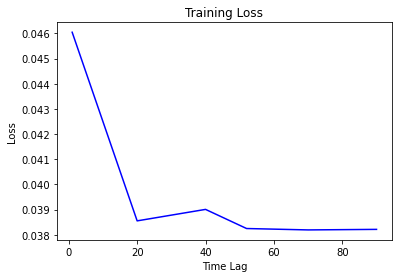

In [11]:
loss = []

for result_ in result:
    lags, error = result_
    loss.append(error)

plt.plot(time_lags, loss, 'b', label='Loss')
plt.title('Training Loss')
plt.xlabel('Time Lag')
plt.ylabel('Loss')
plt.show()

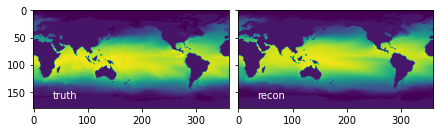

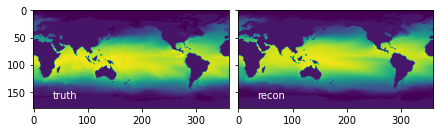

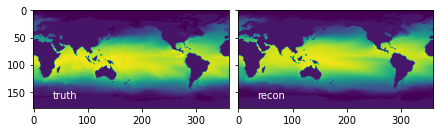

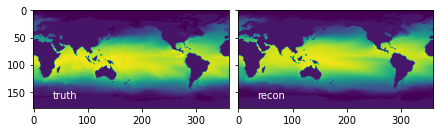

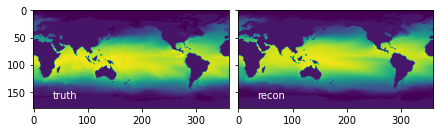

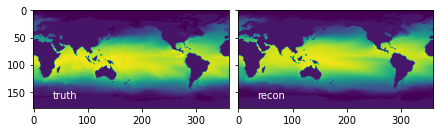

In [23]:
from processdata import load_full_SST

for test_recon in recons_final:
    
    # SST data with world map indices for plotting
    full_SST, sst_locs = load_full_SST()
    full_test_truth = full_SST[test_indices, :]

    # replacing SST data with our reconstruction
    full_test_recon = full_test_truth.copy()
    full_test_recon[:,sst_locs] = test_recons

    # reshaping to 2d frames
    for x in [full_test_truth, full_test_recon]:
        x.resize(len(x),180,360)

    plotdata = [full_test_truth, full_test_recon]
    labels = ['truth','recon']
    fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
    for axis,p,label in zip(ax, plotdata, labels):
        axis.imshow(p[0])
        axis.set_aspect('equal')
        axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
        



In [2]:
# Add Gaussian noise function
def add_gaussian_noise(data, mean, std_dev):
    noise = np.random.normal(mean, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data


In [4]:
# Load the data
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]

# Reset initial parameters
num_sensors = 3
lags = 52
gaussian_noises = [0, 0.25, 0.5, 0.75, 1]  # Specify the range of noise (standard deviation) levels 
mean = 0  # Mean of the Gaussian noise
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)


In [5]:
result = []
recons_final = []

for gaussian_noise in gaussian_noises:
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
        
    noisy_data = add_gaussian_noise(all_data_in, mean, gaussian_noise)

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(noisy_data[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(noisy_data[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(noisy_data[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=20, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    result.append((gaussian_noise, error))
    recons_final.append(test_recons)


epoch: 20 valid_error: tensor(0.3755): 100%|████| 20/20 [00:54<00:00,  2.73s/it]


In [6]:
# Print the results
for result_ in result:
    noise, error = result_
    print(f"Gaussian noise: {noise}, Loss: {error}")

Gaussian noise: 0, Loss: 0.03889806941151619
Gaussian noise: 0.25, Loss: 0.040487807244062424
Gaussian noise: 0.5, Loss: 0.04756521061062813
Gaussian noise: 0.75, Loss: 0.05875903740525246
Gaussian noise: 1, Loss: 0.07844959944486618


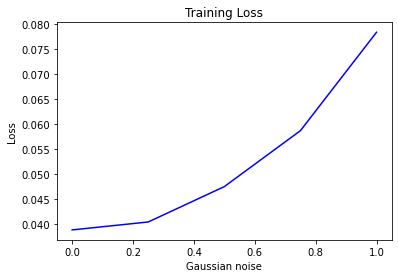

In [7]:
loss = []

for result_ in result:
    noise, error = result_
    loss.append(error)

plt.plot(gaussian_noises, loss, 'b', label='Loss')
plt.title('Training Loss')
plt.xlabel('Gaussian noise')
plt.ylabel('Loss')
plt.show()

In [2]:
# Load the data
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]

# Reset initial parameters
num_sensors = [1, 3, 5, 10]
lags = 52


In [3]:
result = []
recons_final = []

for num_sensors in num_sensors:
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
        

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=20, lr=1e-3, verbose=True, patience=5)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    result.append((num_sensors, error))
    recons_final.append(test_recons)


epoch: 20 valid_error: tensor(0.2240): 100%|████| 20/20 [01:08<00:00,  3.43s/it]


In [4]:
# Print the results
for result_ in result:
    num_sensors, error = result_
    print(f"Number of sensors: {num_sensors}, Loss: {error}")

Number of sensors: 1, Loss: 0.04070238396525383
Number of sensors: 3, Loss: 0.0403682105243206
Number of sensors: 5, Loss: 0.037532880902290344
Number of sensors: 10, Loss: 0.037144824862480164


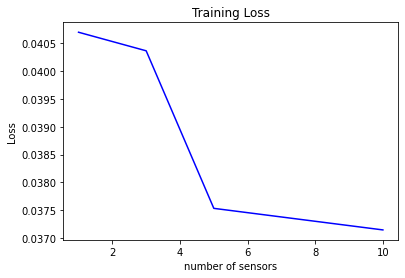

In [8]:
loss = []

for result_ in result:
    num_sensors, error = result_
    loss.append(error)

num_of_sensors = [1, 3, 5, 10]
plt.plot(num_of_sensors, loss, 'b', label='Loss')
plt.title('Training Loss')
plt.xlabel('number of sensors')
plt.ylabel('Loss')
plt.show()